In [28]:
import glob
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

dir = "/ifs/scratch/jls106_gp/nhw2114/data/20231106_synthetic_data"

eakf_metrics_df = pd.read_csv(dir + '/eakf_metrics_all.csv')
epiestim_metrics_df = pd.read_csv(dir + '/epiEstim_metrics_all.csv')
eakf_metrics_badinciks_df = pd.read_csv("/ifs/scratch/jls106_gp/nhw2114/data/20231106_synthetic_data/eakf_metrics_badinciks_all.csv")
esrs_metrics_df = pd.read_csv("/ifs/scratch/jls106_gp/nhw2114/data/20231106_synthetic_data/esrs_metrics_all.csv")

In [2]:
# eakf_metrics_badinciks_df[['method', 'rt_peak_rmse', 'rt_rmse', 'rt_last_epi_day_rmse',
#        'data_rmse', 'data_rmse_last_epi_day', 'avg_w2', 'avg_kl',
#        'avg_w2_last_epi_day', 'avg_kl_last_epi_day', 'in_ci', 'ens_var',
#        'in_ci_last_day', 'ens_var_last_day', 'in_ci_last_epi_day',
#        'ens_var_last_epi_day']].groupby('method').mean().round(4)

In [3]:
# esrs_metrics_df[['method', 'in_ci', 'ens_var', 'in_ci_last_day', 'ens_var_last_day',
#        'in_ci_last_epi_day', 'ens_var_last_epi_day']].groupby('method').mean().round(4)

In [4]:
merge_df = eakf_metrics_badinciks_df.merge(esrs_metrics_df, on=["param","method"], how="left")
merge_df.loc[merge_df.method == "smooth inflation","in_ci_x"] = merge_df.loc[merge_df.method == "smooth inflation","in_ci_y"]
merge_df.loc[merge_df.method == "smooth inflation","ens_var_x"] = merge_df.loc[merge_df.method == "smooth inflation","ens_var_y"]
merge_df.loc[merge_df.method == "smooth inflation","in_ci_last_day_x"] = merge_df.loc[merge_df.method == "smooth inflation","in_ci_last_day_y"]
merge_df.loc[merge_df.method == "smooth inflation","ens_var_last_day_x"] = merge_df.loc[merge_df.method == "smooth inflation","ens_var_last_day_y"]
merge_df.loc[merge_df.method == "smooth inflation","in_ci_last_epi_day_x"] = merge_df.loc[merge_df.method == "smooth inflation","in_ci_last_epi_day_y"]
merge_df.loc[merge_df.method == "smooth inflation","ens_var_last_epi_day_x"] = merge_df.loc[merge_df.method == "smooth inflation","ens_var_last_epi_day_y"]

In [5]:
merge_df.drop(columns=["in_ci_y","ens_var_y","in_ci_last_day_y","ens_var_last_day_y","in_ci_last_epi_day_y","ens_var_last_epi_day_y"], inplace=True)
merge_df.rename(columns={
    "in_ci_x" : "in_ci",
    "ens_var_x" : "ens_var",
    "in_ci_last_day_x" : "in_ci_last_day",
    "ens_var_last_day_x" : "ens_var_last_day",
    "in_ci_last_epi_day_x" : "in_ci_last_epi_day",
    "ens_var_last_epi_day_x" : "ens_var_last_epi_day",
}, inplace=True)

In [6]:
def compute_ci(df, by_col):
    
    mean_df = df.groupby(by_col).mean()
    median_df = df.groupby(by_col).median()
    std_df = df.groupby(by_col).std()
    n_df = df.groupby(by_col).count()

    lower_df = mean_df - 1.96 * std_df / np.sqrt(n_df)
    upper_df = mean_df + 1.96 * std_df / np.sqrt(n_df)
    # add suffixes
    lower_df = lower_df.add_suffix('_lower')
    upper_df = upper_df.add_suffix('_upper')
    mean_df = mean_df.add_suffix('_mean')
    median_df = median_df.add_suffix('_median')
    # merge
    merge_df = lower_df.merge(mean_df, on=by_col)
    merge_df = merge_df.merge(upper_df, on=by_col)
    merge_df = merge_df.merge(median_df, on=by_col)
    
    return merge_df

def dataframe_to_latex(df, columns, titles, metric_dict=None, degree=2):
    """
    Convert a Pandas DataFrame with mean, lower, and upper columns to a LaTeX table.

    Parameters:
    - df: Pandas DataFrame.
    - columns: Columns of table.

    Returns:
    - LaTeX table string.
    """
    df = df[list(titles.keys())]
    # Column row
    tab_arg = "l|" * len(columns)
    latex_table = "\ begin{tabular}{|" + tab_arg + "} \hline "
    latex_table += " & ".join([titles[col] for col in df.columns])
    latex_table += " \\\\\n \hline "
    # Data rows
    for metric, title in metric_dict.items():
        latex_table += f"{title} & "
        
        mean = df.loc[df.metric == metric + "_mean"].round(degree).values.tolist()[0]
        lower = df.loc[df.metric == metric + "_lower"].round(degree).values.tolist()[0]
        upper = df.loc[df.metric == metric + "_upper"].round(degree).values.tolist()[0]
        median = df.loc[df.metric == metric + "_median"].round(degree).values.tolist()[0]
        latex_table += " &  ".join(
            [f"{mean[i]} ({lower[i]}, {upper[i]}) " for i in range(1,len(mean))]
        )
        latex_table += " \\\\\n \hline "
    
    latex_table += "\end{tabular}"

    return latex_table

In [7]:
summ_df = merge_df[['method', 'rt_peak_rmse', 'rt_rmse', 'rt_last_epi_day_rmse',
       'data_rmse', 'data_rmse_last_epi_day', 'avg_w2', 'avg_kl',
       'avg_w2_last_epi_day', 'avg_kl_last_epi_day', 'in_ci', 'ens_var',
       'in_ci_last_day', 'ens_var_last_day', 'in_ci_last_epi_day',
       'ens_var_last_epi_day']].groupby('method').mean().round(4)

In [8]:
epiestim_summ_df = epiestim_metrics_df[['window', 'rt_peak_rmse', 'rt_rmse', 'rt_last_epi_day_rmse',
       'data_rmse', 'data_rmse_last_epi_day', 'avg_w2', 'avg_kl',
       'avg_w2_last_epi_day', 'avg_kl_last_epi_day', 'in_ci', 'ens_var',
       'in_ci_last_day', 'ens_var_last_day', 'in_ci_last_epi_day',
       'ens_var_last_epi_day']].groupby('window').mean(numeric_only=False).round(4)

In [9]:
merge_stats_df = compute_ci(merge_df, "method")
epiestim_stats_df = compute_ci(epiestim_metrics_df, "window")

cols_for_table1 = ['metric', 'adaptive inflation', 'fixed inflation', 'no inflation', 'smooth inflation', 8]
metric_title_dict = {
    # 'rt_peak_rmse' : '$R_t$ RMSE Peak',
    # 'rt_rmse' : '$R_t$ RMSE',
    'in_ci_last_epi_day' : 'True $R_t$ within 95\% CI',
    'rt_last_epi_day_rmse' : '$R_t$ RMSE',
    # 'ens_var' : 'Variance',
    'ens_var_last_epi_day' : 'Ensemble Variance',
    # 'data_rmse' : 'Data RMSE',
    # 'in_ci' : 'True $R_t$ within CI',
    # 'avg_w2' : '$W_2(p,q)$',
    # 'avg_kl' : '$D_{KL}(p || q)$',
    # 'data_rmse_last_epi_day' : 'Data RMSE',
    'avg_w2_last_epi_day' : '$W_2(p,q)$',
    'avg_kl_last_epi_day' : '$D_{KL}(p || q)$',
}
col_title_dict = {
    'metric' : 'Metric',
    'no inflation' : 'no inflation',
    'fixed inflation' : 'fixed inflation',
    'adaptive inflation' : 'adaptive inflation',
    'smooth inflation' : 'EnSRS adaptive inflation', 
    8 : 'EpiEstim',
}
transpose_df = merge_stats_df.T.reset_index().rename(columns={'index':'metric'})
epi_transpose_df = epiestim_stats_df[epiestim_stats_df.index == 8].T.reset_index().rename(columns={'index':'metric'})
transpose_df = transpose_df.merge(epi_transpose_df, on="metric")
print(dataframe_to_latex(transpose_df, cols_for_table1, col_title_dict, metric_title_dict))

\ begin{tabular}{|l|l|l|l|l|l|} \hline Metric & no inflation & fixed inflation & adaptive inflation & EnSRS adaptive inflation & EpiEstim \\
 \hline True $R_t$ within 95\% CI & 0.02 (0.02, 0.03)  &  0.46 (0.46, 0.47)  &  0.84 (0.83, 0.84)  &  0.84 (0.83, 0.84)  &  0.85 (0.85, 0.85)  \\
 \hline $R_t$ RMSE & 1.0 (0.99, 1.0)  &  0.51 (0.51, 0.51)  &  0.38 (0.38, 0.38)  &  0.17 (0.17, 0.17)  &  0.44 (0.44, 0.44)  \\
 \hline Ensemble Variance & 0.0 (0.0, 0.0)  &  0.03 (0.03, 0.03)  &  0.15 (0.15, 0.16)  &  0.09 (0.09, 0.1)  &  1.26 (1.25, 1.27)  \\
 \hline $W_2(p,q)$ & 0.98 (0.98, 0.98)  &  0.82 (0.82, 0.82)  &  0.66 (0.65, 0.66)  &  0.39 (0.39, 0.39)  &  0.77 (0.76, 0.77)  \\
 \hline $D_{KL}(p || q)$ & 6.63 (6.6, 6.66)  &  3.29 (3.27, 3.31)  &  0.96 (0.96, 0.97)  &  1.02 (1.02, 1.03)  &  5.51 (5.48, 5.53)  \\
 \hline \end{tabular}


In [10]:
min_cols = ['rt_peak_rmse', 'rt_rmse', 'rt_last_epi_day_rmse',
       'data_rmse', 'data_rmse_last_epi_day', 'avg_w2', 'avg_kl',
       'avg_w2_last_epi_day', 'avg_kl_last_epi_day', 'ens_var', 'ens_var_last_day',
       'ens_var_last_epi_day']
max_cols = ['in_ci', 'in_ci_last_day', 'in_ci_last_epi_day']

summ_df[min_cols].idxmin()

rt_peak_rmse                    no inflation
rt_rmse                     smooth inflation
rt_last_epi_day_rmse        smooth inflation
data_rmse                 adaptive inflation
data_rmse_last_epi_day      smooth inflation
avg_w2                      smooth inflation
avg_kl                    adaptive inflation
avg_w2_last_epi_day         smooth inflation
avg_kl_last_epi_day       adaptive inflation
ens_var                         no inflation
ens_var_last_day                no inflation
ens_var_last_epi_day            no inflation
dtype: object

In [11]:
summ_df[max_cols].idxmax()

in_ci                 adaptive inflation
in_ci_last_day        adaptive inflation
in_ci_last_epi_day    adaptive inflation
dtype: object

In [12]:
epiestim_summ_df[min_cols].rank(ascending=False)

,rt_peak_rmse,rt_rmse,rt_last_epi_day_rmse,data_rmse,data_rmse_last_epi_day,avg_w2,avg_kl,avg_w2_last_epi_day,avg_kl_last_epi_day,ens_var,ens_var_last_day,ens_var_last_epi_day
window,,,,,,,,,,,,
1,13.0,1.0,1.0,16.0,19.0,17.0,17.0,16.0,17.0,1.0,1.0,1.0
2,17.0,2.0,2.0,18.0,20.0,19.0,19.0,19.0,19.0,2.0,2.0,2.0
3,19.0,3.0,6.0,20.0,18.0,20.0,20.0,20.0,20.0,3.0,3.0,3.0
4,20.0,4.0,11.0,19.0,17.0,18.0,18.0,18.0,18.0,4.0,4.0,4.0
5,18.0,5.0,15.0,17.0,16.0,16.0,16.0,17.0,16.0,5.0,5.0,5.0
6,16.0,6.0,17.0,15.0,15.0,15.0,15.0,15.0,15.0,6.0,6.0,6.0
7,15.0,7.0,19.0,14.0,14.0,14.0,14.0,14.0,14.0,7.0,7.0,7.0
8,14.0,8.0,20.0,13.0,13.0,13.0,13.0,13.0,13.0,8.0,8.0,8.0
9,12.0,9.0,18.0,12.0,12.0,12.0,12.0,12.0,12.0,9.0,9.0,9.0


In [13]:
epiestim_summ_df[min_cols].idxmin()

rt_peak_rmse               4
rt_rmse                   20
rt_last_epi_day_rmse       8
data_rmse                  3
data_rmse_last_epi_day     2
avg_w2                     3
avg_kl                     3
avg_w2_last_epi_day        3
avg_kl_last_epi_day        3
ens_var                   20
ens_var_last_day          20
ens_var_last_epi_day      20
dtype: int64

In [14]:
epiestim_summ_df[max_cols].idxmax()

in_ci                 3
in_ci_last_day        1
in_ci_last_epi_day    1
dtype: int64

# Look for examples

In [15]:
table_cols = [
    'method',
    'in_ci_last_epi_day',
    'rt_last_epi_day_rmse',
    'avg_w2_last_epi_day',
    'avg_kl_last_epi_day',
]

max_params = merge_df.iloc[merge_df[table_cols].groupby("method").idxmax().values.flatten()].param.unique()
min_params = merge_df.iloc[merge_df[table_cols].groupby("method").idxmin().values.flatten()].param.unique()

# append the min and max params for epiestim
epiesim_max_params = epiestim_metrics_df.iloc[epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, table_cols[1:]].idxmax().values].param.unique()
epiesim_min_params = epiestim_metrics_df.iloc[epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, table_cols[1:]].idxmin().values].param.unique()

max_params = np.unique(np.append(max_params, epiesim_max_params))
min_params = np.unique(np.append(max_params, epiesim_min_params))

In [16]:
# params that are closest to the mean metric value

mean_df = merge_df[table_cols].groupby('method').mean()
mean_df.columns = mean_df.columns + "_mean"

mean_diff_df = merge_df[table_cols + ['param']].merge(mean_df, on="method")
mean_diff_df['in_ci_last_epi_day'] = np.abs(mean_diff_df['in_ci_last_epi_day'] - mean_diff_df['in_ci_last_epi_day_mean'])
mean_diff_df['rt_last_epi_day_rmse'] = np.abs(mean_diff_df['rt_last_epi_day_rmse'] - mean_diff_df['rt_last_epi_day_rmse_mean'])
mean_diff_df['avg_w2_last_epi_day'] = np.abs(mean_diff_df['avg_w2_last_epi_day'] - mean_diff_df['avg_w2_last_epi_day_mean'])
mean_diff_df['avg_kl_last_epi_day'] = np.abs(mean_diff_df['avg_kl_last_epi_day'] - mean_diff_df['avg_kl_last_epi_day_mean'])

mean_params = mean_diff_df.iloc[mean_diff_df[table_cols + ['param']].groupby("method").idxmin().values.flatten()].param.unique()

# append epiestim mean params
epiestim_mean_df = epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, table_cols[1:]].mean()
mean_params = np.append(mean_params, [epiestim_metrics_df.iloc[np.abs(epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, tt] - epiestim_mean_df[tt]).idxmin()].param for tt in table_cols[1:]])

In [17]:
params = np.append(min_params, max_params)
params = np.append(params, mean_params)
params

array([  2236,   3457,   6115,  16729,  21258,  55685,  58428,  63679,
        69090,  70286,  73071,  85084,  96475,  96799,  98225,  99368,
       100184, 100185,  21258,  55685,  58428,  63679,  69090,  70286,
        73071,  85084,  96475,  96799,  98225,  99368, 100184, 100185,
        46482,  66815,  43056,   5863,      1,   3348,  45193,   8019,
         8298,   3775,  27533,  28485,  40299,  84882,  89399,  57066,
        49477,  21258,  43775,  55741,  36206])

In [18]:
import shutil

# copy synthetic data from one to the other
data_dir = "/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data"
copy_dir = "/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper"

import shutil
for pp in params:
    shutil.copyfile(f"{data_dir}/{pp}_synthetic_data.pkl", f"{copy_dir}/{pp}_synthetic_data.pkl")
    shutil.copyfile(f"{data_dir}/{pp}_synthetic_plots.pdf", f"{copy_dir}/{pp}_synthetic_plots.pdf")

# Compute correlations with params

In [15]:
param_df = pd.read_csv("param_list.csv")
param_df["param"] = param_df.index

In [16]:
param_df['early_day'] = -1/param_df.k * np.log((param_df.rt_1 - param_df.rt_0)/(1.01*param_df.rt_0 - param_df.rt_0)-1) + param_df.midpoint
param_df['late_day'] = -1/param_df.k * np.log((param_df.rt_1 - param_df.rt_0)/(0.99*param_df.rt_1 - param_df.rt_0)-1) + param_df.midpoint
param_df['day_diff'] = param_df['late_day'] - param_df['early_day']
param_df['rt_diff'] = param_df['rt_1'] - param_df['rt_0']

In [17]:
merge_df = merge_df.merge(param_df, on="param")
epiestim_metrics_df = epiestim_metrics_df.merge(param_df, on="param")

In [18]:
metric_cols = ['rt_peak_rmse', 'rt_rmse', 'rt_last_epi_day_rmse',
       'data_rmse', 'data_rmse_last_epi_day', 'avg_w2', 'avg_kl', 'in_ci',
       'ens_var', 'in_ci_last_day', 'ens_var_last_day', 'in_ci_last_epi_day',
       'ens_var_last_epi_day', 'avg_w2_last_epi_day', 'avg_kl_last_epi_day']
param_cols = ['rt_0', 'rt_1', 'midpoint', 'k', 'early_day', 'late_day', 'day_diff', 'rt_diff']

In [ ]:
from sklearn.manifold import TSNE
X = param_df.loc[param_df.param.isin(merge_df.param), ['rt_0', 'rt_1', 'midpoint', 'k']]
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

# Add legends and labels
plt.title('t-SNE Plot of Parameters for Synthetic Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Show the plot
plt.show()

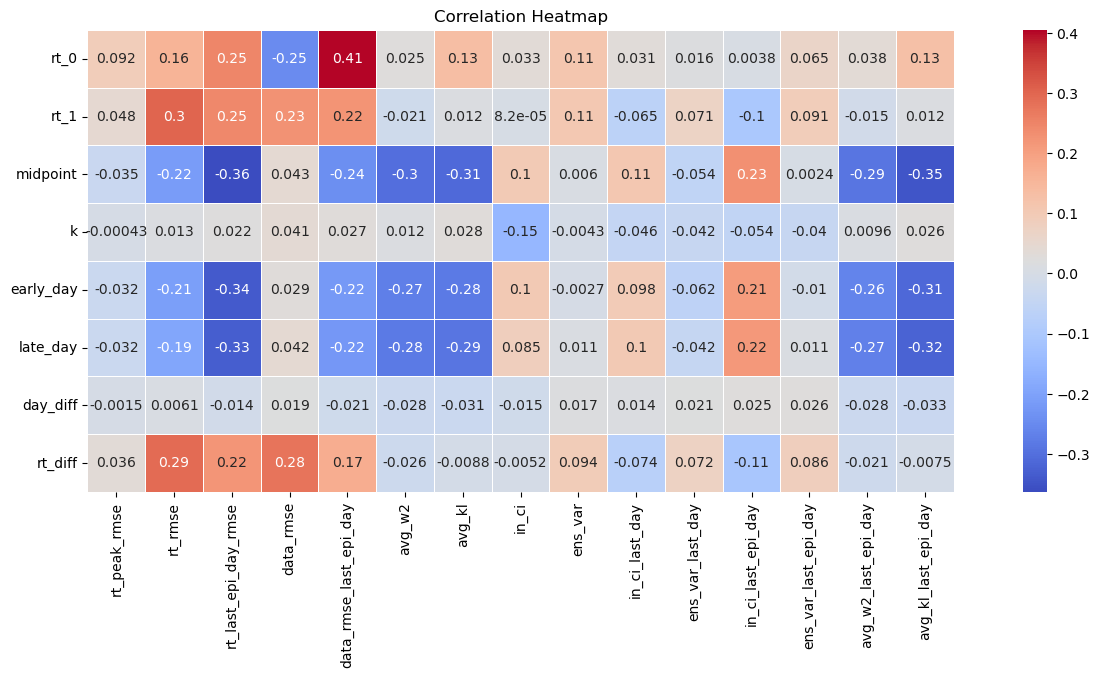

In [19]:
import seaborn as sns

correlation_matrix = merge_df[metric_cols + param_cols].corr()
correlation_matrix_subset = correlation_matrix.loc[correlation_matrix.index.isin(param_cols),metric_cols]

# Create a heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(correlation_matrix_subset, annot=True, cmap='coolwarm', linewidths=.5, square=True)

# Customize the plot
plt.title('Correlation Heatmap')
plt.show()

correlation_matrix_subset.to_csv("correlation.csv", index=False)

In [20]:
# move files
# files = glob.glob(dir + '/*epiEsim_plots.pdf')

# new_dir = "/ifs/scratch/jls106_gp/nhw2114/data/20231106_synthetic_data/pdf_archive/"
# for f in tqdm(files):
#     new_path = new_dir + os.path.basename(f)
#     os.rename(f, new_path)


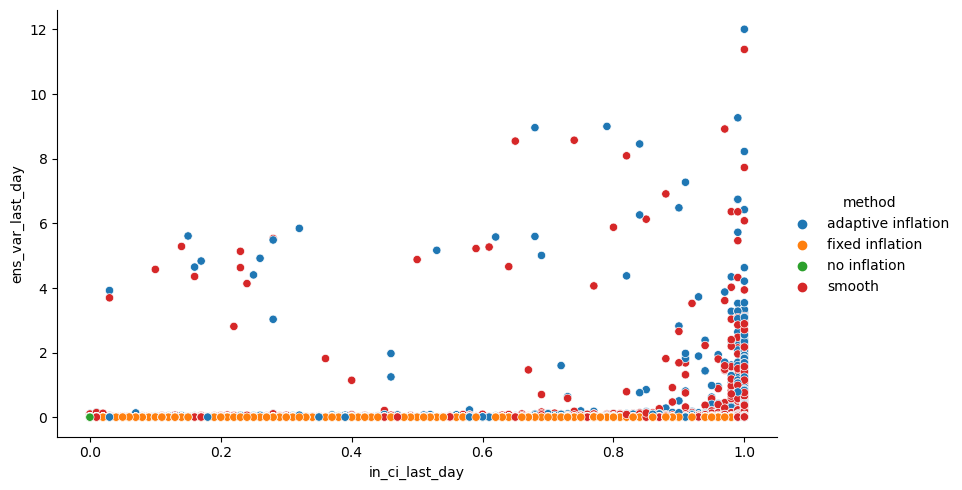

In [21]:
import seaborn as sns

_methods = ['adaptive inflation', 'fixed inflation', 'no inflation', 'smooth']
sns.relplot(data=eakf_metrics_df, x='in_ci_last_day', y='ens_var_last_day', hue='method', hue_order=_methods, aspect=1.61)
plt.show()

/ifs/scratch/jls106_gp/nhw2114/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


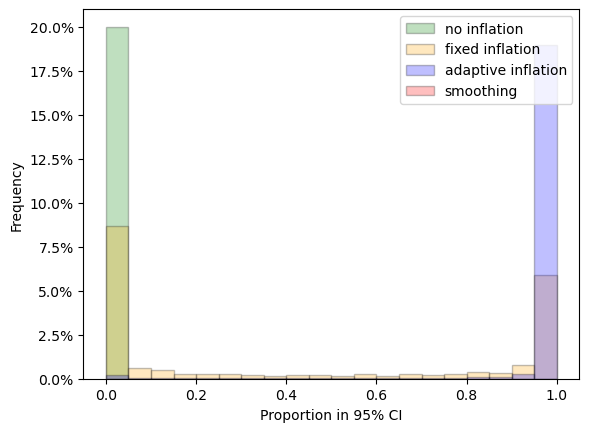

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
no_ci = merge_df.loc[merge_df["method"] == "no inflation", "in_ci_last_day"]
fix_ci = merge_df.loc[merge_df["method"] == "fixed inflation", "in_ci_last_day"]
adapt_ci = merge_df.loc[merge_df["method"] == "adaptive inflation", "in_ci_last_day"]
smooth_ci = merge_df.loc[merge_df["method"] == "smooth", "in_ci_last_day"]
ax.hist(no_ci, bins=20, color='green', label="no inflation", edgecolor='black', alpha=0.25, density=True, range=[0.0, 1.0])
ax.hist(fix_ci, bins=20, color='orange', label="fixed inflation", edgecolor='black', alpha=0.25, density=True)
ax.hist(adapt_ci, bins=20, color='blue', label="adaptive inflation", edgecolor='black', alpha=0.25, density=True) 
ax.hist(smooth_ci, bins=20, color='red', label="smoothing", edgecolor='black', alpha=0.25, density=True) 

ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
plt.xlabel('Proportion in 95% CI')
plt.ylabel('Frequency')
plt.legend()

In [24]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# no_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "no inflation", "ens_var_last_day"]
# # fix_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "fixed inflation", "ens_var_last_day"]
# adapt_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "adaptive inflation", "ens_var_last_day"]
# smooth_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "smooth", "ens_var_last_day"]

# # ax.hist(no_ci, bins=5, color='green', label="no inflation", edgecolor='black', alpha=0.25, density=True, range=[0.0, 1.0])
# ax.hist(fix_ci, bins=5, color='orange', label="fixed inflation", edgecolor='black', alpha=0.25, density=True)
# ax.hist(adapt_ci, bins=5, color='blue', label="adaptive inflation", edgecolor='black', alpha=0.25, density=True) 
# ax.hist(smooth_ci, bins=5, color='red', label="smoothing", edgecolor='black', alpha=0.25, density=True) 

# # ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
# plt.title('Histogram Example')
# plt.xlabel('Ensemble Variance')
# plt.ylabel('Frequency')
# plt.legend()

In [16]:
# from scipy.stats.kde import gaussian_kde

# x = eakf_metrics_df.loc[eakf_metrics_df["method"] == "adaptive inflation", "in_ci_last_day"]
# y = eakf_metrics_df.loc[eakf_metrics_df["method"] == "adaptive inflation", "ens_var_last_day"]
# Z, xedges, yedges = np.histogram2d(x, y,bins=5)
# plt.pcolormesh(xedges, yedges, Z.T)
# plt.colorbar()



# Compute last day

In [21]:
import pickle
from epyfilter import simulate_data

good_param_df = pd.read_csv("good_param_list.csv")
pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl" for param in good_param_df.param]

def open_pickle(pickle_file):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    return data

last_day_array = np.empty(shape=(len(pickle_list), 2))

In [60]:
for i, pp in enumerate(tqdm(pickle_list)):
    param = os.path.basename(pp).split("_")[0]
    data = open_pickle(pp)
    if len(np.where(data.i_true == 0)[0]) == 1:
        last_day = len(data.i_true)
    else:
        last_day = np.where(data.i_true == 0)[0][1]
    last_day_array[i] = [param, last_day]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47871/47871 [35:25<00:00, 22.52it/s]


In [66]:
last_day_df = pd.DataFrame(last_day_array, columns=['param','last_epidemic_day'], dtype=int)
last_day_df.to_csv("/ifs/scratch/jls106_gp/nhw2114/repos/rt-estimation/src/epyfilter/c2b2/last_epidemic_day.csv", index=False)

In [69]:
last_day_df[last_day_df.last_epidemic_day.isna()]

,param,last_epidemic_day


# Fix last epi day

In [22]:
last_day_df = pd.read_csv("/ifs/scratch/jls106_gp/nhw2114/repos/rt-estimation/src/epyfilter/c2b2/last_epidemic_day.csv")

In [44]:
to_do_params = []
last_epi_days = []

for index, row in tqdm(last_day_df.iterrows()):
    param = row['param']
    last_epi_day = row['last_epidemic_day']
    pp = f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl"
    data = open_pickle(pp)
    zero_days = np.where(data.i_true == 0)[0]
    if len(zero_days) == 1:  # never reached 0
        last_day = len(data.i_true)
    else:
        first_zero_day = zero_days[1]
        non_zero_days = np.where(data.i_true > 10)[0]
        if np.any(non_zero_days > first_zero_day):
            last_days = zero_days[zero_days > np.max(non_zero_days)]
            if len(last_days) == 0:
                last_day = len(data.i_true)
            else:
                last_day = last_days[0]
        else:
            last_day = first_zero_day
    if last_epi_day != last_day:
        to_do_params.append(param)
        last_epi_days.append(last_day)
        

47871it [1:23:21,  9.57it/s]


In [56]:
pd.DataFrame(np.array((to_do_params, last_epi_days)).T, columns=["param", "last_epi_day"])

,param,last_epi_day
0,73347,256
1,88316,248
2,13462,287
3,86220,267
4,24054,233
...,...,...
8613,25224,236
8614,26482,243
8615,86176,267
8616,4932,294


In [38]:
# for param in to_do_params[0:10]:
#     pp = f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl"
#     data = open_pickle(pp)
#     last_epi_day = last_day_df.loc[last_day_df.param == param, 'last_epidemic_day'].values[0]
#     plt.plot(data.i_true, '.')
#     plt.axvline(x = last_epi_day)

array([  0, 162, 173, 174, 175, 176, 177, 179, 182, 184, 186])

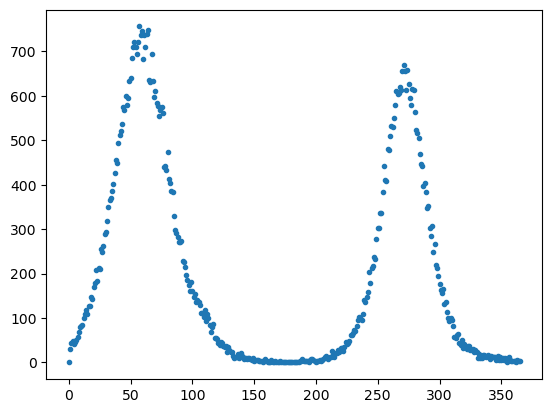

In [29]:
plt.plot(data.i_true, '.')
np.where(data.i_true == 0)[0]

In [36]:
import pickle
from epyfilter import simulate_data
from tqdm import tqdm

good_param_df = pd.read_csv("good_param_list.csv")
pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl" for param in good_param_df.param]

def compute_late_day(data):
    beta_1 = data.rt_1 / data.t_I
    beta_0 = data.rt_0 / data.t_I
    late_day = -1/data.k * np.log((beta_1 - beta_0)/(0.99*beta_1 - beta_0)-1) + data.midpoint
    late_day = int(late_day)
    return late_day

def compute_peaks(data):
    det_data = simulate_data.simulate_data(**data.true_params, run_deterministic=True)
    peak_days, = np.where(np.diff(np.sign(np.diff(det_data.i_true))) == -2)  # days where it increases before then decreases
    peak_days = peak_days[:2]  # just take first two days
    return peak_days

def open_pickle(pickle_file):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    return data

In [37]:
data_files = glob.glob(dir + '/*_data_distribution.csv')
done_params = [int(os.path.basename(f).split("_")[0]) for f in data_files]
todo_params = list(set(good_param_df.param) - set(done_params))

pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl" for param in todo_params]

In [39]:
pickle_list = ["/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/71564_synthetic_data.pkl"]

In [40]:
for pp in tqdm(pickle_list):
    param = os.path.basename(pp).split("_")[0]
    data = open_pickle(pp)
    data_distribution_df = pd.DataFrame(data.data_distribution, columns=[f"sample{x}" for x in range(1,301)])
    data_distribution_df["day"] = range(len(data_distribution_df))
    data_distribution_df["late_day"] = compute_late_day(data)
    peaks = compute_peaks(data)
    data_distribution_df["peak1"] = peaks[0]
    data_distribution_df["peak2"] = peaks[1]
    
    data_distribution_df.to_csv(f"{dir}/{param}_data_distribution.csv", index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


In [42]:
len(glob.glob(dir + '/*_data_distribution.csv'))

47871

# Fix Single Epidemics

In [7]:
pickles = glob.glob(dir + '/*.pkl')

In [8]:
import pickle
def open_pickle(pickle_file):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    return data

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100185/100185 [3:04:18<00:00,  9.06it/s]


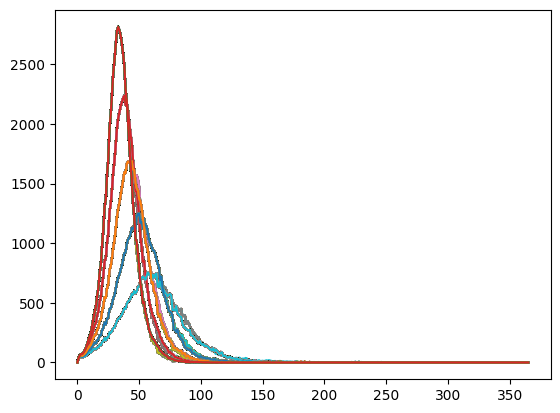

In [10]:
from tqdm import tqdm
from scipy.signal import find_peaks

bad_params = []
for file in tqdm(pickles):
    data = open_pickle(file)

    window_size = 10  # Adjust this window size as needed
    smoothed_data = np.convolve(data.i_true, np.ones(window_size) / window_size, mode='valid')
    peaks, _ = find_peaks(smoothed_data, height=100, prominence=10)
    if len(peaks) < 2:
        bad_params.append(file)
        plt.plot(data.i_true)

In [11]:
len(bad_params)

52314

In [14]:
pd.DataFrame(bad_params).to_csv("one_epidemic_curve.csv", index=False)

In [18]:
bad_metric_files = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{os.path.basename(b).split('_')[0]}_eakf_metrics.csv" for b in bad_params]

In [21]:
dfs = []
for file in tqdm(files):
    if file not in bad_metric_files:
        df = pd.read_csv(file)
        param = os.path.basename(file).split("_")[0]
        df["param"] = param
        dfs.append(df)

good_combined_df = pd.concat(dfs, ignore_index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100185/100185 [07:22<00:00, 226.36it/s]


In [22]:
good_combined_df[["method", "rt_peak_rmse", "rt_rmse", "data_rmse", "avg_w2", "avg_kl", "in_ci"]].groupby("method").mean()

,rt_peak_rmse,rt_rmse,data_rmse,avg_w2,avg_kl,in_ci
method,,,,,,
adaptive inflation,0.084815,0.374231,47.154245,0.642203,0.952536,0.662593
fixed inflation,0.044096,0.599377,68.936821,0.811197,3.306851,0.172927
no inflation,0.024710,1.763012,117.320087,0.988873,7.159461,0.000000
smooth,0.043557,0.253248,58.496632,0.383990,0.968416,0.543410


Text(0, 0.5, 'Count')

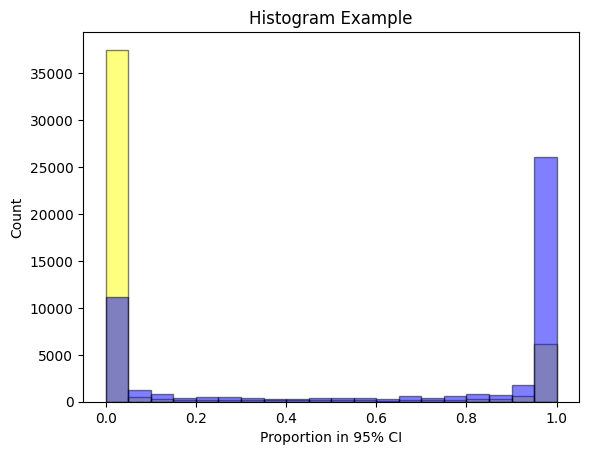

In [23]:
plt.hist(good_combined_df.loc[good_combined_df["method"] == "fixed inflation", "in_ci"], bins=20, color='yellow', edgecolor='black', alpha=0.5)
plt.hist(good_combined_df.loc[good_combined_df["method"] == "adaptive inflation", "in_ci"], bins=20, color='blue', edgecolor='black', alpha=0.5)
plt.title('Histogram Example')
plt.xlabel('Proportion in 95% CI')
plt.ylabel('Count')

In [42]:
pd.DataFrame(good_combined_df.param.unique(), columns=["param"]).to_csv("good_param_list.csv", index=False)

In [45]:
df = pd.read_csv("good_param_list.csv")
pickle_files = df.iloc[1:1000, 0]

In [46]:
pickle_files = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{p}_synthetic_data.pkl" for p in pickle_files]

In [51]:
4788/200 * 3

71.82000000000001

In [55]:
files = glob.glob(dir + '/*_for_epiestim.csv')

In [58]:
pd.read_csv(files[0])

,rt,i,prop_S
0,1.3,33.742320,0.99869
1,1.3,42.500996,0.99826
2,1.3,45.972273,0.99778
3,1.3,38.297496,0.99736
4,1.3,38.854358,0.99690
...,...,...,...
360,4.7,0.000000,0.58860
361,4.7,0.396479,0.58860
362,4.7,0.000000,0.58860
363,4.7,0.000000,0.58860
